**2η Εργαστηριακή Άσκηση στο μάθημα Ψηφιακή Επεξεργασία Σήματος 2024**

| Ονοματεπώνυμα | ΑΜ |
|----------------|----|
| Γεώργιος Αλέξανδρος Γεωργαντζάς        | 03120017 |
| Βλάσιος Σκουλής        | 03120065 |

**Μέρος 1ο - Ψυχοακουστικό Μοντέλο 1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io.wavfile import write
import scipy as sp
import IPython
import soundfile as sf

**Μέρος 1ο**

/var/folders/0s/3zzp9lz97h34qxk2kjr5c5wh0000gn/T/ipykernel_40940/1120343008.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, music_stereo = sp.io.wavfile.read('./dsp24_material_lab2/music_dsp2024.wav')


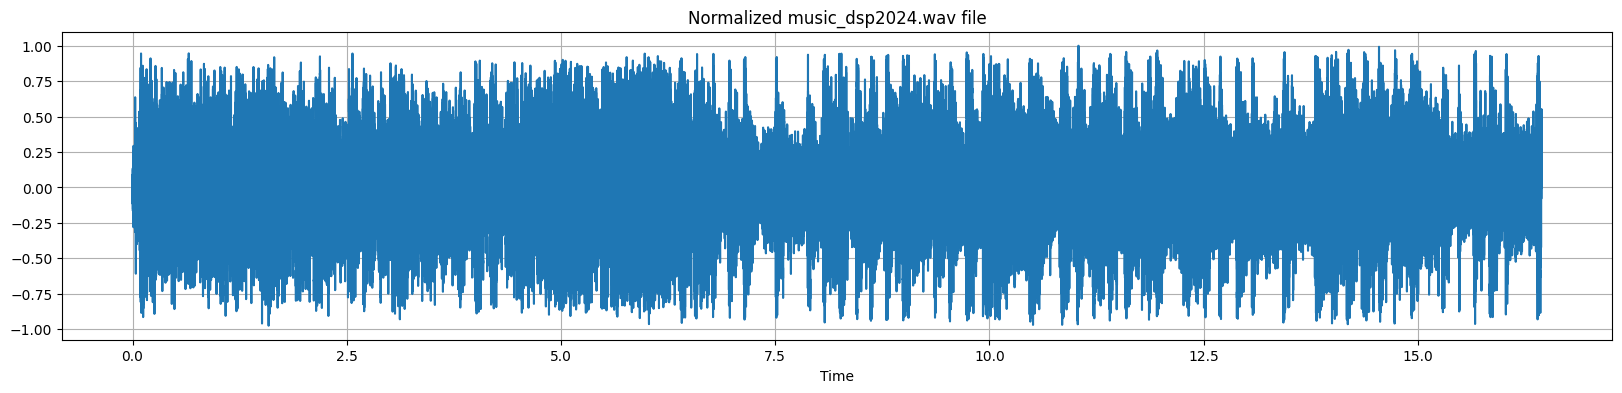

In [2]:
# 1.0

# Read the stereo audio file
fs, music_stereo = sp.io.wavfile.read('./dsp24_material_lab2/music_dsp2024.wav')

# Convert stereo to mono
music = np.mean(music_stereo, axis=1)

# Normalize the audio to range from -1 to 1
max_abs = np.max(np.abs(music))
music = music / max_abs

# Create time array
time = np.arange(len(music)) / fs

# Plot the normalized mono audio in time domain
fig = plt.figure(figsize=(20, 4))
plt.plot(time, music)
plt.xlabel('Time')
plt.title('Normalized music_dsp2024.wav file')
plt.grid(True)
plt.show()

# Display the normalized mono audio
IPython.display.display(IPython.display.Audio(data=music, rate=fs))

In [3]:
# 1.1

def bark_scale(f):
    """
    Frequency (Hz) to Bark scale converter
    
    Args:
    f: input array of frequencies in Hz
    
    Returns:
    b: frequencies converted to Bark scale
    """
    b = 13 * np.arctan(0.00076 * f) + 3.5 * np.arctan((f / 7500) ** 2)
    return b

In [4]:
# 1.1

# Define parameters
L = 512  # Length of each segment
N = 512  # FFT size
hop_size = 0  # Hop size between segment
PN = 90.302

# Create hanning and rectangular windows
hanning = np.hanning(L)

# Pad music so that it can be segmented by hanning windows
pad_width = len(hanning) - len(music) % len(hanning)
music_padded = np.pad(music, pad_width=(0, pad_width), mode='constant', constant_values=0)

# Initialize list to store FFT results. Each element in this list is another list that contains the fft results of each window.
# That means that this list is of size rows x columns, where the number of rows is equal to the number of samples return by fft (512)
# while the number of columns is equal to the number of segments we got by splitting the signal (1417).
segments_fft_list = []

# Initialize list to store Power Spectrum results. 
P_k = []

# Segment total signal into windows, apply windows, and compute FFT
for i in range(0, len(music_padded), L+hop_size):
    segment = music_padded[i:i+L] * hanning
    segment_fft = np.fft.fft(segment, N)
    segment_fft = np.abs(segment_fft)
    segments_fft_list.append(segment_fft)

# Calculate Power Spectrum of each window
for window_fft in segments_fft_list:
    P_k.append((PN+10*np.log10(window_fft**2))[:N//2])

# P_k is a 2D numpy array. It should of dimensions 256 x 1417. Each of the 1417 columns represent a segment of our original signal.
# Each segment contains 256 points. So P_k stores the power spectrum results for each window, in each column. 
P_k = np.array(P_k).transpose()

#Parameters for plotting
segment_time_duration = np.linspace(0, L-1, L)
segment_time_duration = segment_time_duration/fs

# We will use 2 windows for plotting, in order to present our results for the rest of this exercise.
window_0 = 500 
window_1 = 1000

# DFT returnes samples. Not real frequencies. We use np.fft.fftfreq() to translate to real frequency content in Hz.
freqs = np.fft.fftfreq(N, d=1/fs)
freqs = abs(freqs[1:N//2+1])

# From Hz to Bark
bark_freqs = bark_scale(freqs)

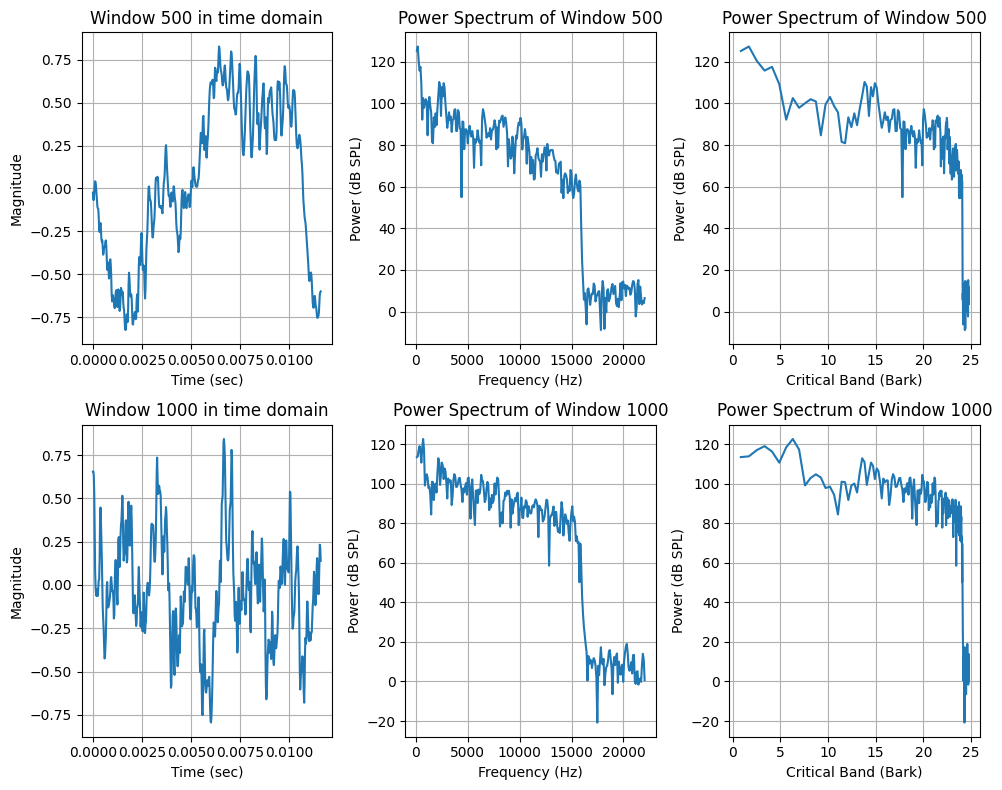

In [5]:
# 1.1

# Plotting Starts
plt.figure(figsize=(10, 8))

# Plot window_0 in time domain
plt.subplot(2, 3, 1)
plt.plot(segment_time_duration, music[N*window_0:N*(window_0+1)])
plt.xlabel('Time (sec)')
plt.ylabel('Magnitude')
plt.title('Window 500 in time domain')
plt.grid(True)

# Plot the power spectrum of window_0 in relation to real frequency (Hz)
plt.subplot(2, 3, 2)
plt.plot(freqs, P_k[:, window_0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB SPL)')
plt.title('Power Spectrum of Window 500')
plt.grid(True)

# Plot the power spectrum of window_0 in relation to bark
plt.subplot(2, 3, 3)
plt.plot(bark_freqs, P_k[:, window_0])
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Power Spectrum of Window 500')
plt.grid(True)

# Plot window_1 in time domain
plt.subplot(2, 3, 4)
plt.plot(segment_time_duration, music[N*window_1:N*(window_1+1)])
plt.xlabel('Time (sec)')
plt.ylabel('Magnitude')
plt.title('Window 1000 in time domain')
plt.grid(True)

# Plot the power spectrum of window_1 in relation to real frequency (Hz)
plt.subplot(2, 3, 5)
plt.plot(freqs, P_k[:, window_1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB SPL)')
plt.title('Power Spectrum of Window 1000')
plt.grid(True)

# Plot the power spectrum of window_1 in relation to bark
plt.subplot(2, 3, 6)
plt.plot(bark_freqs, P_k[:, window_1])
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Power Spectrum of Window 1000')
plt.grid(True)
# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [6]:
# 1.2

def dk(k):
    if 2 < k < 63:
        D_k = [2, 2]
    elif k < 127:
        D_k = [2, 3]
    elif k <= 250:
        D_k = [2, 6]
    else:
        D_k = [0, 0]
    return D_k

In [7]:
# 1.2

# Load P_NM
P_NM = np.load("./dsp24_material_lab2/P_NM-24.npy")

def find_masks(window):
    """
    Find tonal masks based on the power spectrum.

    Args:
    window: Power Spectrum of a Window

    Returns:
    ST: Boolean array indicating tonal masks of input window
    """

    st = np.zeros_like(window, dtype=bool)  # Initialize tonal mask array

    # Find tonal masks
    for k in range(2, 250):
        d1, d2 = dk(k)
        if window[k] > window[k - 1] and window[k] > window[k + 1]:
            st[k] = 1
            for i in range(d1, d2):
                if not(window[k] > window[k - i] + 7 and window[k] > window[k + i] + 7):
                    st[k] = 0
    return st


# ST is a boolean 2D array. Should be of shape (256,1417). It contains 0s everywhere, except from where there are tonal masks detected.
ST = np.zeros_like(P_k)

# P_TM is to store the power of each tonal mask. Should be of shape (256, 1417).
P_TM = np.zeros_like(ST)
#Find tonal masks off all windows
for window in range(P_k.shape[1]):
    ST[:, window] = find_masks(P_k[:, window])
    coords_of_tonal_masks = np.where(ST[:, window] > 0)
    for k in coords_of_tonal_masks:
        P_TM[k, window] = 10 * np.log10(10**(0.1 * P_k[k, window]) + 10**(0.1 * P_k[k, window]) + 10**(0.1 * P_k[k, window]))

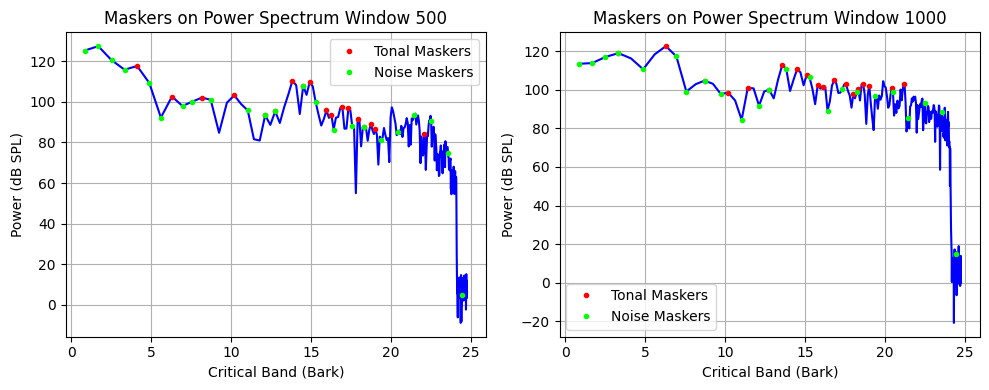

In [8]:
# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(bark_freqs, P_k[:, window_0], color='blue')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TM[:, window_0] != 0)[0]
noise_mask_indices = np.where(P_NM[:, window_0] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_0], 'ro', label='Tonal Maskers', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_0], 'o', color='lime', label='Noise Maskers', markersize=3)
# Set labels and title
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum Window 500')
plt.legend()
plt.grid()
# Add legend at bottom left

plt.subplot(1, 2, 2)
plt.plot(bark_freqs, P_k[:, window_1], color='blue')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TM[:, window_1] != 0)[0]
noise_mask_indices = np.where(P_NM[:, window_1] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_1], 'ro', label='Tonal Maskers', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_1], 'o', color='lime', label='Noise Maskers', markersize=3)
# Set labels and title
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum Window 1000')
# Add legend at bottom left
plt.legend()
plt.grid()
# Show plot
plt.tight_layout()
plt.show()

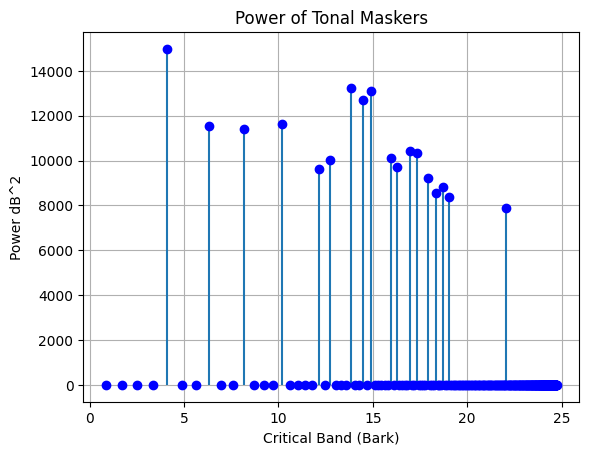

In [9]:
plt.stem(bark_freqs, P_TM[:, window_0]**2, linefmt='', markerfmt='bo', basefmt=' ')
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power dB^2')
plt.title("Power of Tonal Maskers")
plt.grid()

In [10]:
# 1.3

# Load P_NMc
P_NMc = np.load("./dsp24_material_lab2/P_NMc-24.npy")

# Load P_TMc
P_TMc = np.load("./dsp24_material_lab2/P_TMc-24.npy")

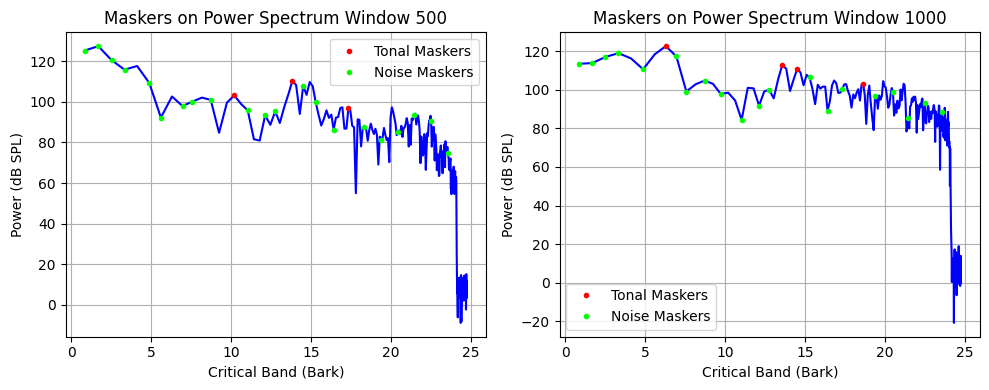

In [11]:
# 1.3

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(bark_freqs, P_k[:, window_0], color='blue')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TMc[:, window_0] != 0)[0]
noise_mask_indices = np.where(P_NMc[:, window_0] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_0], 'ro', label='Tonal Maskers', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_0], 'o', color='lime', label='Noise Maskers', markersize=3)
# Set labels and title
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum Window 500')
plt.legend()
plt.grid()
# Add legend at bottom left

plt.subplot(1, 2, 2)
plt.plot(bark_freqs, P_k[:, window_1], color='blue')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TMc[:, window_1] != 0)[0]
noise_mask_indices = np.where(P_NMc[:, window_1] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_1], 'ro', label='Tonal Maskers', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_1], 'o', color='lime', label='Noise Maskers', markersize=3)
# Set labels and title
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum Window 1000')
# Add legend at bottom left
plt.legend()
plt.grid()
# Show plot
plt.tight_layout()
plt.show()


In [12]:
# 1.4

def SF(db, power):
    sf = 0
    if db >= -3 and db < -1:
        sf = 17*db-.4*power+11
    elif db >= -1 and db < 0:
        sf = (.4*power+6)*db
    elif db >= 0 and db < 1:
        sf = -17*db
    elif db >= 1 and db < 8:
        sf = (.15*power-17)*db-.15*power
    return sf

def T_M(P_M, noise=False):                 
    t_m_total = np.zeros((P_M.shape[0], P_M.shape[1], P_M.shape[0]))
    for window in range(P_M.shape[1]):
        t_m = np.zeros((P_M.shape[0],  P_M.shape[0]))
        discrete_coords = np.where(P_M[:, window] > 0)[0]
        for j in discrete_coords:
            power = P_M[j, window]
            for i in range(t_m.shape[0]):
                freq_i = freqs[i]
                freq_j = freqs[j]
                db = bark_scale(freq_i)-bark_scale(freq_j)
                flag = True
                if not(db >= -3 and db < 8):
                    flag = False
                if noise:
                    t_m_total[j, window, i] = power-0.175*bark_scale(freq_j)+SF(db, power)-2.025 if flag else 0
                else:
                    t_m_total[j, window, i] = power-0.275*bark_scale(freq_j)+SF(db, power)-6.025 if flag else 0
    return t_m_total

In [13]:
# 1.4

T_TM = T_M(P_TMc)

In [14]:
# 1.4

T_NM = T_M(P_NMc, True)

In [15]:
# 1.5
def abs_thresh(f):
    return 3.64 * (f / 1000) ** (-0.8) - 6.5 * np.exp(-0.6 * (f / 1000 - 3.3) ** 2) + 10 ** (-3) * (f / 1000) ** 4

def T(t_nm, t_tm):
    t_g = np.zeros((t_nm.shape[0], t_nm.shape[1]))
    for window in range(t_nm.shape[1]):
        for i in range(t_nm.shape[2]):
            sum_tm = np.sum(10**(0.1*t_tm[:, window, i]))
            sum_nm = np.sum(10**(0.1*t_nm[:, window, i]))
            Tq = abs_thresh(freqs[i]) if i > 0 else 40
            t_g[i, window] = 10*np.log10(10**(0.1*Tq)+sum_tm+sum_nm)
    return t_g

T_g = T(T_NM, T_TM)

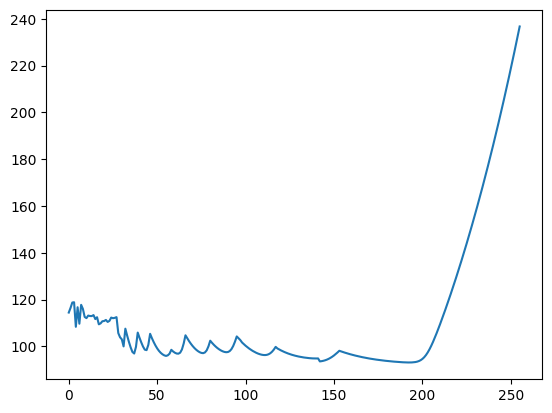

In [16]:
plt.plot(T_g[:, 1000])

In [17]:
import scipy.io as sio

# Load the .mat file
mat_contents = sio.loadmat('T_g.mat')

# Extract the T_g array
T_g = mat_contents['T_g']

In [18]:
T_g = np.array(T_g)

In [19]:
T_g.shape

(256, 1417)

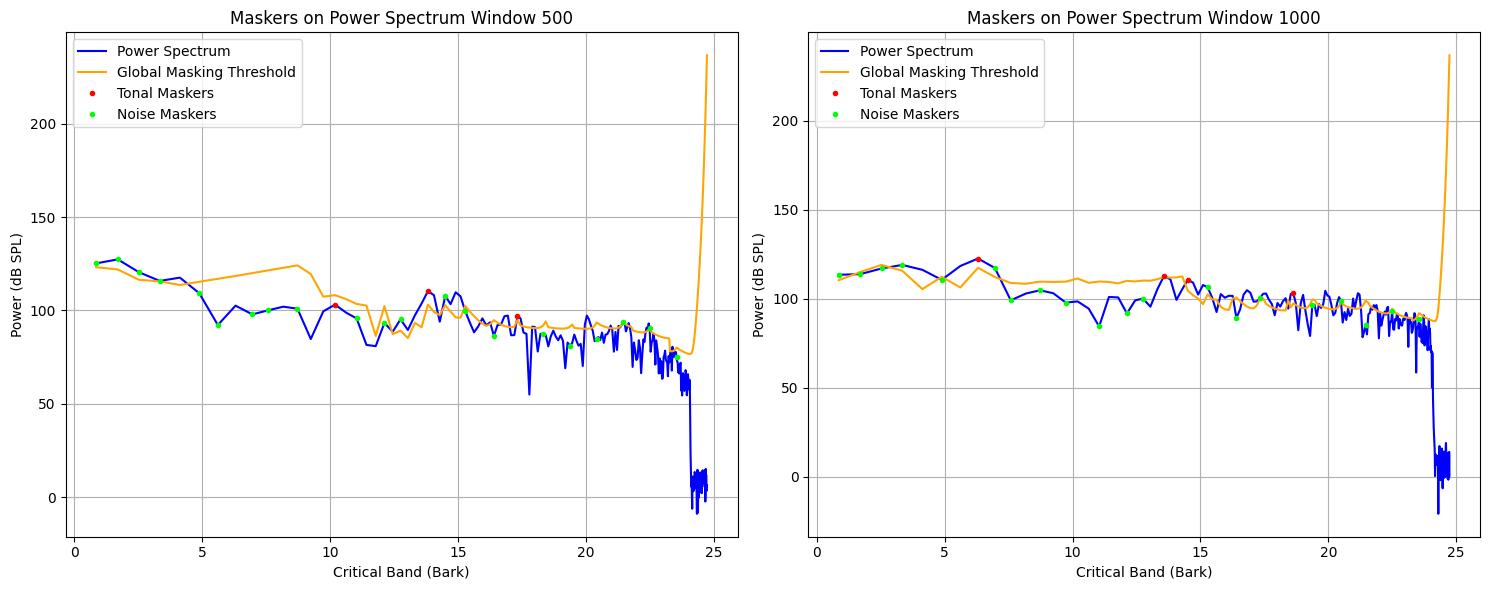

In [20]:
# 1.5

# Plotting
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(bark_freqs, P_k[:, window_0], color='blue', label='Power Spectrum')
plt.plot(bark_freqs, T_g[:, window_0], color='orange', label='Global Masking Threshold')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TMc[:, window_0] != 0)[0]
noise_mask_indices = np.where(P_NMc[:, window_0] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_0], 'ro', label='Tonal Maskers', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_0], 'o', color='lime', label='Noise Maskers', markersize=3)
# Set labels and title
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum Window 500')
plt.legend()
plt.grid()
# Add legend at bottom left

plt.subplot(1, 2, 2)
plt.plot(bark_freqs, P_k[:, window_1], color='blue', label='Power Spectrum')
plt.plot(bark_freqs, T_g[:, window_1], color='orange', label='Global Masking Threshold')
# Overlay positions of tonal masks with red color
mask_indices = np.where(P_TMc[:, window_1] != 0)[0]
noise_mask_indices = np.where(P_NMc[:, window_1] != 0)[0]
plt.plot(bark_freqs[mask_indices], P_k[mask_indices, window_1], 'ro', label='Tonal Maskers', markersize=3)
plt.plot(bark_freqs[noise_mask_indices], P_k[noise_mask_indices, window_1], 'o', color='lime', label='Noise Maskers', markersize=3)
# Set labels and title
plt.xlabel('Critical Band (Bark)')
plt.ylabel('Power (dB SPL)')
plt.title('Maskers on Power Spectrum Window 1000')
# Add legend at bottom left
plt.legend()
plt.grid()
# Show plot
plt.tight_layout()
plt.show()


**Μέρος 2ο**

<function matplotlib.pyplot.show(close=None, block=None)>

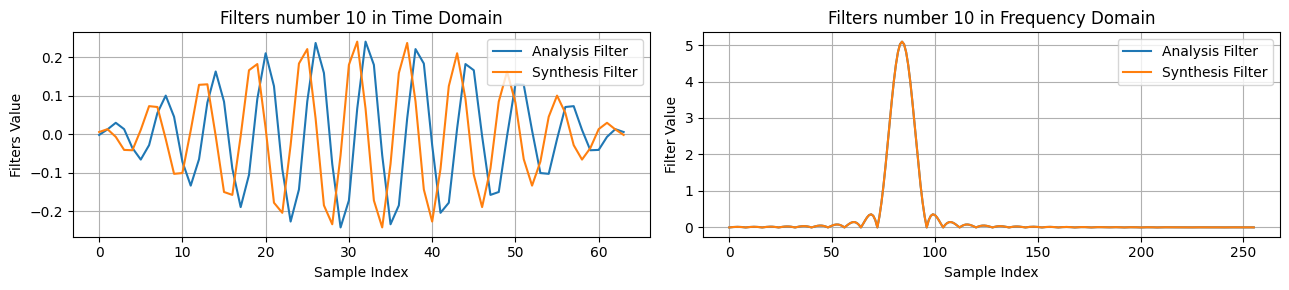

In [21]:
# 2.0

def analysis_filter(M, k):
    L = 2 * M
    n = np.arange(L)
    hk = np.sin((n + 0.5) * np.pi / (2 * M)) * np.sqrt(2 / M) * np.cos(((2 * n + M + 1) * (2 * k + 1) * np.pi) / (4 * M))
    return hk

def synthesis_filter(M, k):
    return analysis_filter(M, k)[::-1]  # Reverse the analysis filter to get the synthesis filter

M = 32  # Number of filters
analysis_filters = [analysis_filter(M, k) for k in range(M)]
synthesis_filters = [synthesis_filter(M, k) for k in range(M)]

# Plot filters
plt.figure(figsize=(13, 3))
plt.subplot(1, 2, 1)
plt.plot(analysis_filters[10], label='Analysis Filter')
plt.plot(synthesis_filters[10], label='Synthesis Filter')
plt.title(f'Filters number 10 in Time Domain')
plt.xlabel('Sample Index')
plt.ylabel('Filters Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(abs(np.fft.fft(analysis_filters[10], 512)[:256]), label='Analysis Filter')
plt.plot(abs(np.fft.fft(synthesis_filters[10], 512)[:256]), label='Synthesis Filter')
plt.title(f'Filters number 10 in Frequency Domain')
plt.xlabel('Sample Index')
plt.ylabel('Filter Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

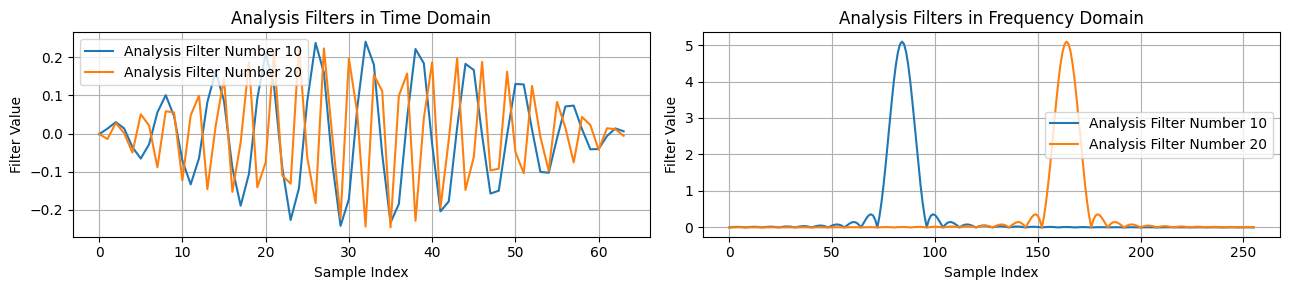

In [22]:
# 2.0

# Plot analysis filters
plt.figure(figsize=(13, 3))
plt.subplot(1, 2, 1)
plt.plot(analysis_filters[10], label='Analysis Filter Number 10')
plt.plot(analysis_filters[20], label='Analysis Filter Number 20')
plt.title(f'Analysis Filters in Time Domain')
plt.xlabel('Sample Index')
plt.ylabel('Filter Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(abs(np.fft.fft(analysis_filters[10], 512)[:256]), label='Analysis Filter Number 10')
plt.plot(abs(np.fft.fft(analysis_filters[20], 512)[:256]), label='Analysis Filter Number 20')
plt.title(f'Analysis Filters in Frequency Domain')
plt.xlabel('Sample Index')
plt.ylabel('Filter Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show

In [24]:
import numpy as np

def upsample(signal, factor):
    # Create an array of zeros with the required length
    upsampled_signal = np.zeros(len(signal) * factor - (factor - 1), dtype=signal.dtype)
    
    # Copy the original signal values to every `factor`-th element of the upsampled signal
    upsampled_signal[::factor] = signal
    # Add one additional zero at the end
    upsampled_signal = np.pad(upsampled_signal, (0, factor-1), mode='constant')
    return upsampled_signal

# # Test the function
# x = np.arange(0, 18, 1, dtype=int)
# factor = 3
# y = upsample(x, factor)

In [25]:
# 2.1

def filterbank_analysis(x):
    M = 32  # Number of filters
    analysis_filters = [analysis_filter(M, k) for k in range(M)]
    #print(x.shape)
    #print(analysis_filters[12].shape)
    v = np.zeros((np.convolve(x, analysis_filters[12])[0::M].shape[0], M))
    # Segment total signal into windows, apply windows, and compute FFT
    for k in range(M):
        v[:, k] = np.convolve(x, analysis_filters[k])[0::M]
    return v

# 2.3

def filterbank_synthesis(quan_y_k):
    #print(quan_y_k.shape)
    M = 32  # Number of filters
    synthesis_filters = [synthesis_filter(M, k) for k in range(M)]
    #print(synthesis_filters[12].shape)
    #print((upsample(quan_y_k[:, 0], M).shape))
    w_k = np.zeros((upsample(quan_y_k[:, 0], M).shape[0], M))
    #print(w_k.shape)
    w = np.zeros((np.convolve(upsample(quan_y_k[:, 0], M), synthesis_filters[0]).shape[0], M))
    #print(w.shape)
    reconstructed_segment = np.zeros(quan_y_k.shape[0])
    for q in range(M):
        w_k[:, q] = upsample(quan_y_k[:, q], M)
        w[:, q] = np.convolve(w_k[:, q], synthesis_filters[q])
    reconstructed_segment = np.sum(w, axis=1)
    return reconstructed_segment

In [77]:
def adaptive_quantizer(segment, segment_idx, T_g_segment):
    #print(segment.shape)
    y_k = filterbank_analysis(segment)
    #print(y_k.shape)
    quantized_y_k = np.zeros_like(y_k)
    #print(quantized_y_k.shape)
    #print(T_g.shape)
    for q in range(M):
        low = 8*q
        high = 8*(q+1)-1
        #print(y_k[:, q])
        T_g_min = np.min(T_g_segment[low:high])
        #print(T_g_min)
        R = 2 ** 16
        B_k = int(np.log2((R / T_g_min) - 1))
        #print(f"q: {q}: ", T_g[low:high])
        levels = 2 ** B_k
        print(levels)
        # Define partition for the quantization
        min_y_q = np.min(y_k[:, q])
        max_y_q = np.max(y_k[:, q])
        D = (max_y_q - min_y_q) / levels
        partition = min_y_q + np.arange(1, levels-1) * D
        # Define codebook for the quantization
        codebook = min_y_q + np.arange(levels-1) * D + D / 2
        index = np.digitize(y_k[:, q], partition) - 1
        quantized_y_k[:, q] = codebook[index]
        #print(codebook)
    rec_seg = filterbank_synthesis(quantized_y_k)
    return rec_seg

In [ ]:
final_signal = []
L = 512
for segment_idx, i in enumerate(range(0, len(music_padded), L + hop_size)):
    segment = music_padded[i:i + L]
    final_signal.append(adaptive_quantizer(segment, segment_idx, T_g[:, segment_idx]))

final_signal = np.array(final_signal)

512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512


In [28]:
#print(final_signal.shape)

In [29]:
x = np.arange(0, 10, 1)
print(x[2:])

[2 3 4 5 6 7 8 9]


In [74]:
L = final_signal.shape[1]
R = 512
reconstructed_signal = final_signal[:R, 0]

for frame in range(1, final_signal.shape[0]):
    temp_reconstructed_y = final_signal[frame-1, R:L] + final_signal[frame, 0:L-R]
    reconstructed_signal = np.concatenate((reconstructed_signal, temp_reconstructed_y))
    reconstructed_signal = np.concatenate((reconstructed_signal, final_signal[frame, L-R:R]))

# Ignore the first 2M samples
reconstructed_signal = reconstructed_signal[2*M:]


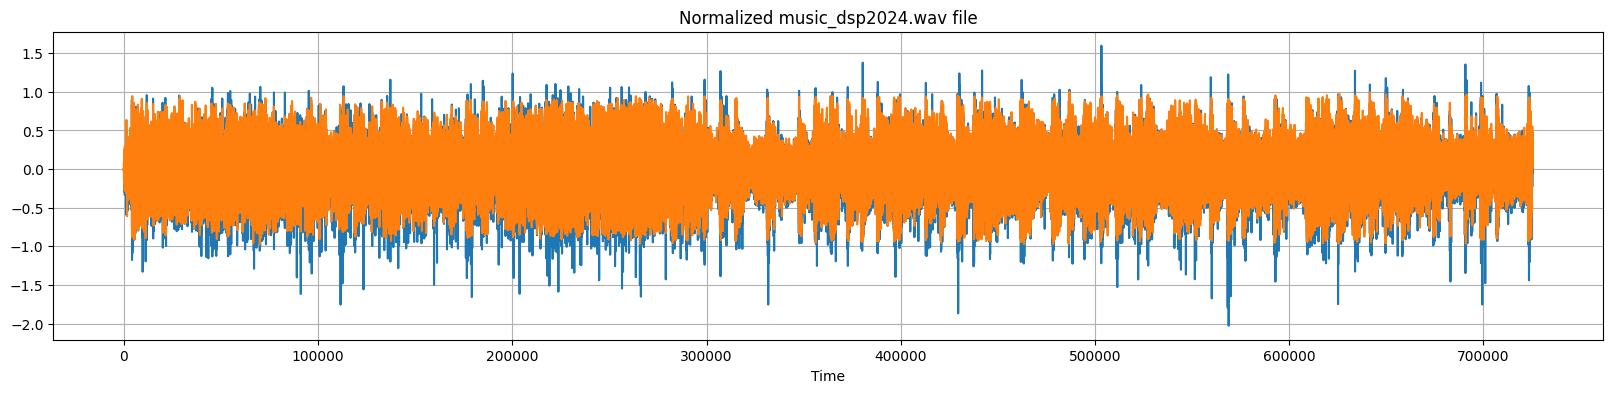

In [75]:
# Plot the normalized mono audio in time domain
fig = plt.figure(figsize=(20, 4))
plt.plot(reconstructed_signal)
plt.plot(music)
plt.xlabel('Time')
plt.title('Normalized music_dsp2024.wav file')
plt.grid(True)
plt.show()
IPython.display.display(IPython.display.Audio(reconstructed_signal, rate=fs))

In [33]:
import scipy.io as sio


mat_contents = sio.loadmat('reconstructed_y.mat')
reconstructed_y = mat_contents['reconstructed_y']
reconstructed_y = np.array(reconstructed_y)[0, :]

In [34]:
print(reconstructed_y.shape)

(725441,)


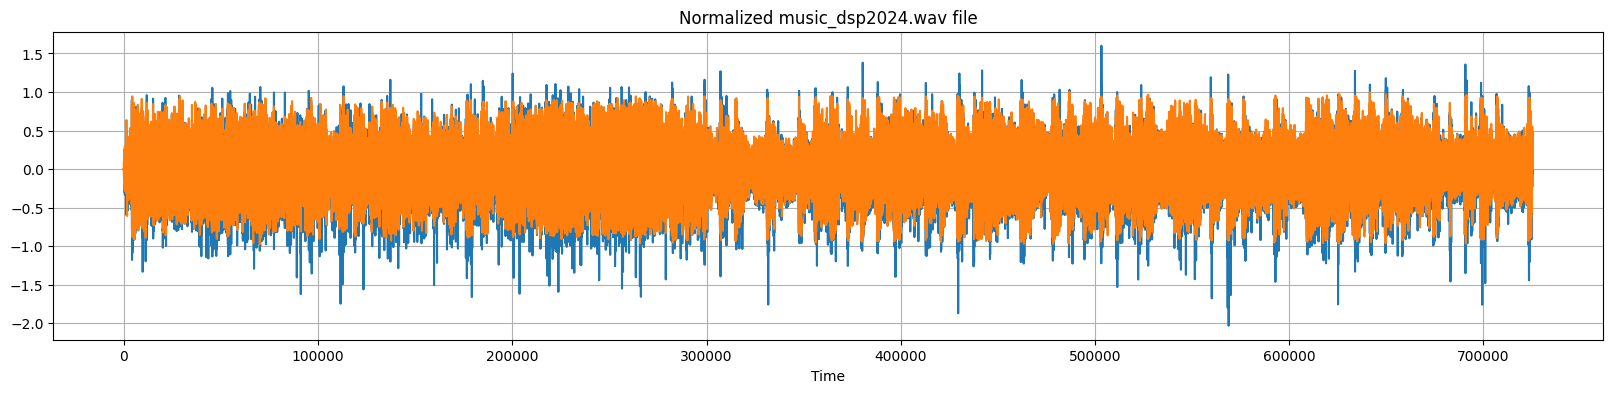

In [40]:
fig = plt.figure(figsize=(20, 4))
plt.plot(reconstructed_signal)
plt.plot(reconstructed_y)
plt.xlabel('Time')
plt.title('Normalized music_dsp2024.wav file')
plt.grid(True)
plt.show()
IPython.display.display(IPython.display.Audio(reconstructed_y, rate=fs))
IPython.display.display(IPython.display.Audio(music, rate=fs))